### Automated Diagnosis of Cancer Cells using Supervised Machine Learning

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

#### Project Overview and Goals

---

#### Importing Data

In [2]:
# Load data
cancer_data = load_breast_cancer()

# Select features
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)

# Select target
y = pd.DataFrame(cancer_data.target, columns=['target'])

# Combine features and target into dataframe
cancer_data_df = pd.concat([X, y], axis=1)

---

#### Exploratory Data Analysis

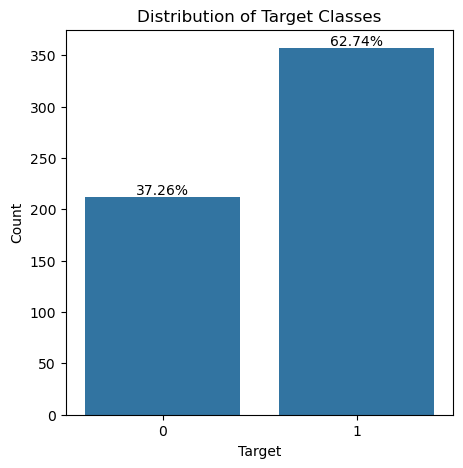

In [3]:
# Countplot
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='target', data=cancer_data_df)

# Calculate counts and proportions
counts = cancer_data_df['target'].value_counts()
total = len(cancer_data_df)

# Add proportions above bars
for p in ax.patches:
    height = p.get_height()
    proportion = height / total
    ax.annotate(
        f"{proportion:.2%}",
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom',
        fontsize=10
    )

plt.title("Distribution of Target Classes")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

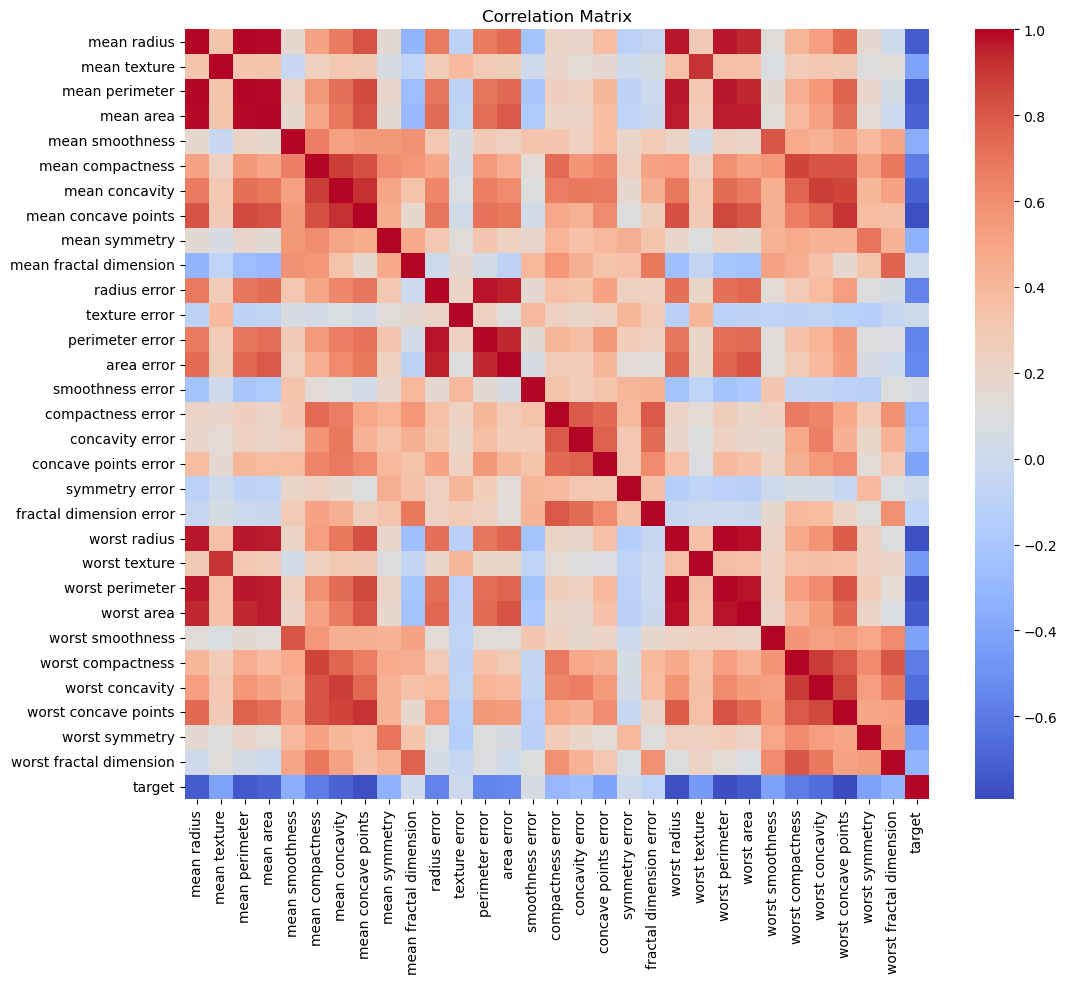

In [4]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(cancer_data_df.corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

---

#### Data Cleaning and Preprocessing

In [5]:
# Drop missing values (if any)
cancer_data_df = cancer_data_df.dropna()

# Drop duplicates (if any)
cancer_data_df = cancer_data_df.drop_duplicates()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Standardize features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to training data only
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

/Users/andy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/andy/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


---

#### Feature Engineering

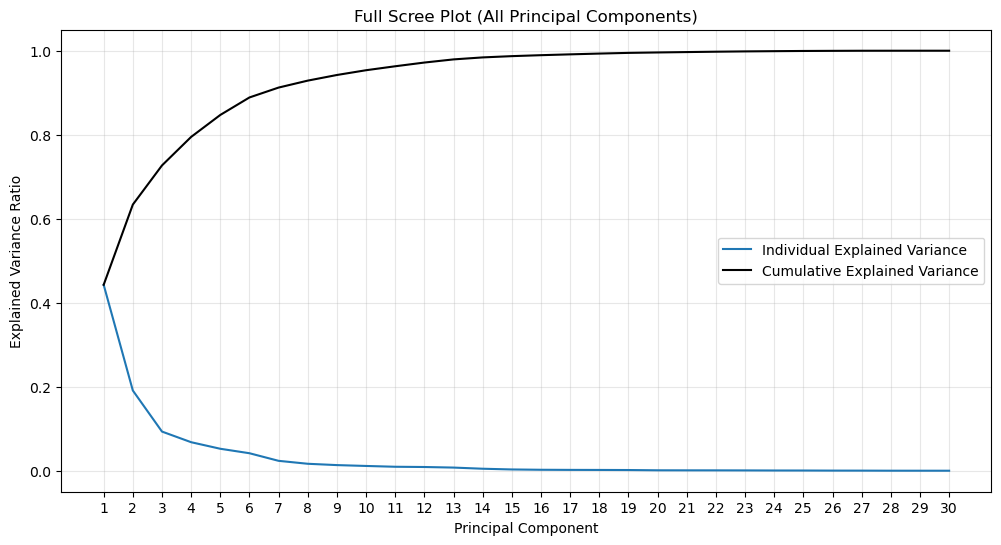

In [6]:
# Fit PCA on scaled training data
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Extract Variances
var_exp = pca_full.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()

plt.figure(figsize=(12,6))

plt.plot(range(1, len(var_exp) + 1), var_exp, label='Individual Explained Variance')
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, color='black', label='Cumulative Explained Variance')

plt.title('Full Scree Plot (All Principal Components)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(var_exp) + 1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [7]:
# Perform PCA
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

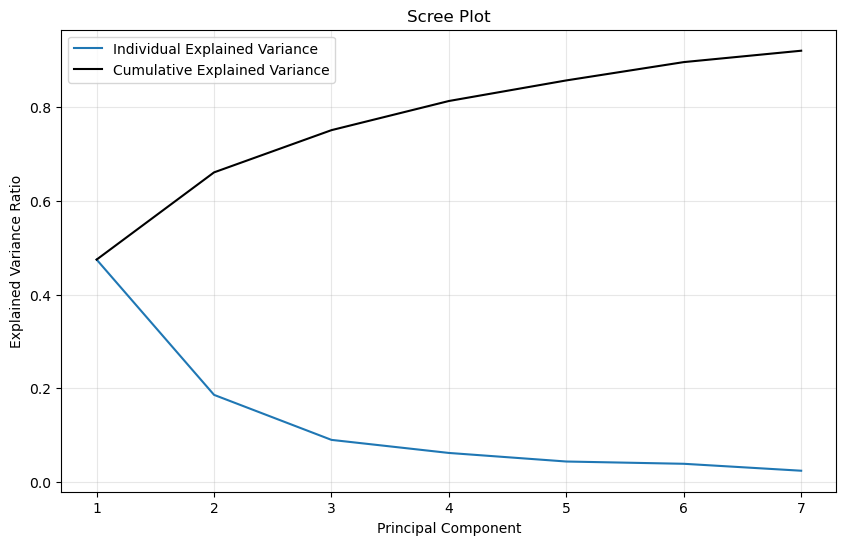

In [8]:
# Extract variances
var_exp = pca.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()

plt.figure(figsize=(10,6))

plt.plot(range(1, len(var_exp) + 1), var_exp, label='Individual Explained Variance')
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, color='black', label='Cumulative Explained Variance')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(var_exp) + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

---

#### Model Building and Training

In [9]:
# Define all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Naive Bayes": GaussianNB()
}

# 
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train.values.ravel()
)

# Fit all models
for name, model in models.items():
    model.fit(X_train_pca, y_train_resampled)

/Users/andy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [10]:
for name, model in models.items():
    y_pred = model.predict(X_test_pca)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

=== SVM (RBF) ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weight

---

#### Model Evaluation

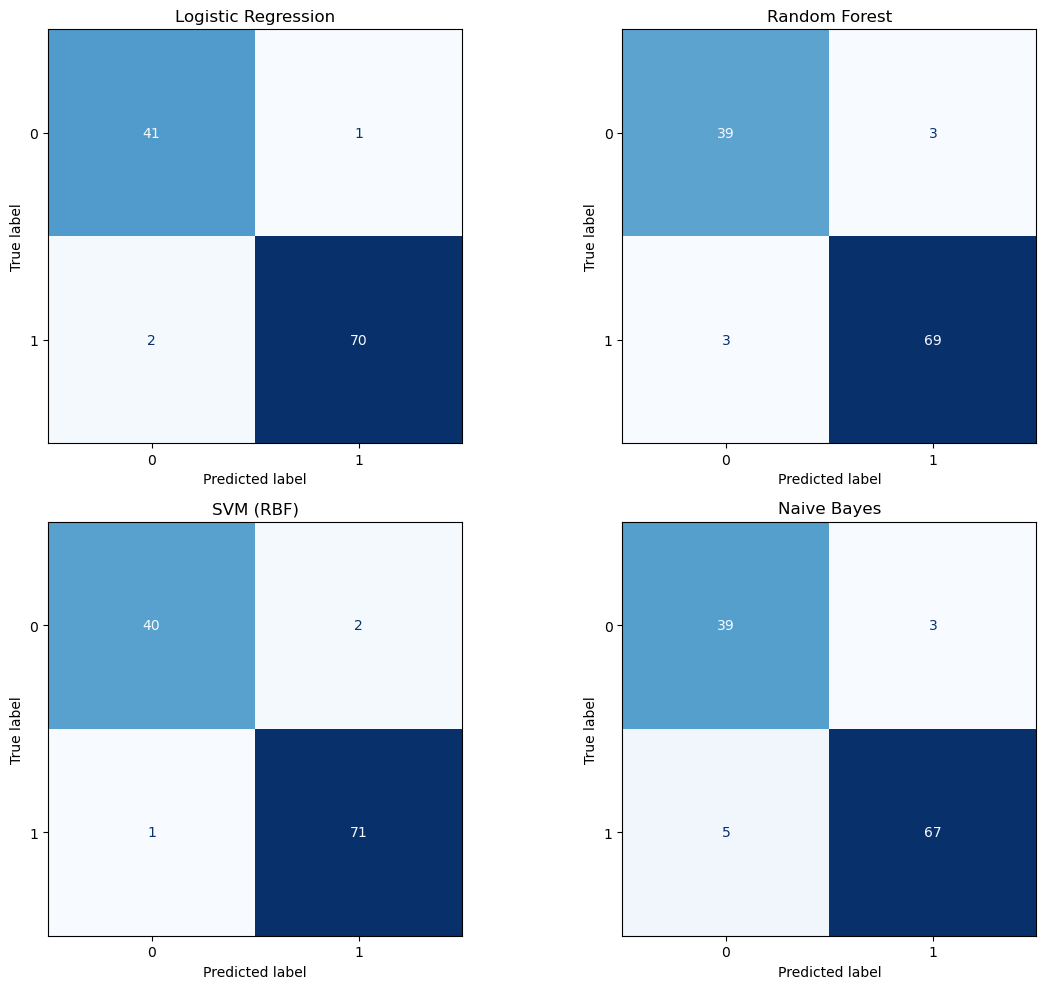

In [11]:
plt.figure(figsize=(12, 10))

for i, (name, model) in enumerate(models.items(), start=1):
    y_pred = model.predict(X_test_pca)

    plt.subplot(2, 2, i)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
    plt.title(name)

plt.tight_layout()
plt.show()

In [12]:
# StratifiedKFold to preserve class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store mean & std
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_pca, y_train_resampled, 
                             cv=cv, scoring='accuracy')
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name}: Mean Accuracy = {scores.mean():.3f}, Std = {scores.std():.3f}")

Logistic Regression: Mean Accuracy = 0.977, Std = 0.007
Random Forest: Mean Accuracy = 0.972, Std = 0.007
SVM (RBF): Mean Accuracy = 0.977, Std = 0.011
Naive Bayes: Mean Accuracy = 0.923, Std = 0.015


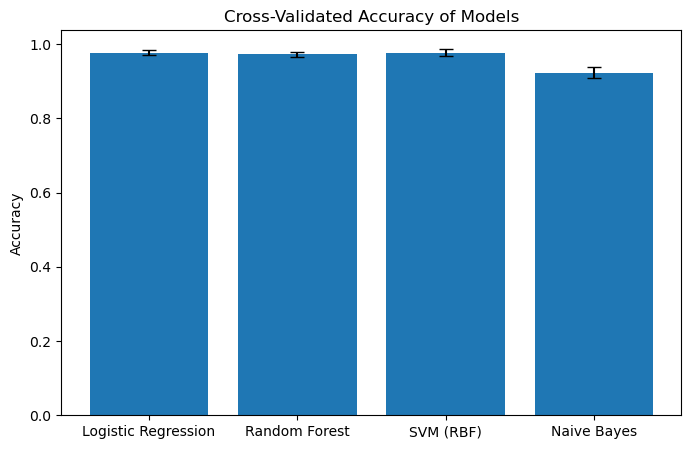

In [13]:
names = list(cv_results.keys())
means = [cv_results[n][0] for n in names]
stds = [cv_results[n][1] for n in names]

plt.figure(figsize=(8,5))
plt.bar(names, means, yerr=stds, capsize=5)
plt.ylabel("Accuracy")
plt.title("Cross-Validated Accuracy of Models")
plt.show()

---

#### Project Results